In [1]:
import pandas as pd, numpy as np
import os
import pickle
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
city = 'Toronto'

# loading saved prophet model
pkl_path = os.path.join(os.path.dirname(os.getcwd()),"dashboard_components","models", \
                    city.lower().replace(" ","_")+"_prophet.pkl")
with open(pkl_path,'rb') as f:
    model = pickle.load(f)

# importing relevant data
data_path = os.path.join(os.path.dirname(os.getcwd()),"dashboard_components","data")
ts_df = pd.read_csv(os.path.join(data_path,"time_series_df.csv"))
ts_df.date = pd.DatetimeIndex(ts_df.date)
ts_df.set_index('date',inplace=True)

In [3]:
ts_df.head()

,Brampton,Calgary,Markham,Mississauga,Montreal,North York,Richmond Hill,Scarborough,Toronto,Vaughan
date,,,,,,,,,,
2010-01-16,1,8,0,0,1,0,0,2,27,0
2010-01-17,0,10,0,0,3,1,0,1,29,0
2010-01-18,0,4,4,0,0,0,0,2,21,0
2010-01-19,0,2,0,0,0,1,0,0,25,0
2010-01-20,0,8,0,3,3,1,0,0,37,0


In [4]:
# making dataframe for prediction and forecasting
future_pd = model.make_future_dataframe(
  periods=52*7, 
  freq='D', 
  include_history=True
  )

out = model.predict(future_pd)
out['fact'] = np.append(ts_df[city].values,np.zeros(52*7))

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
"""
- function to detect anomalies and estimate their importance
- data points where the fact is outside the 95% confidence interval of the predictions are considered to be anomalies
- anomaly importance is determined by how far the fact is from the boundary 
"""
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])
    
    return forecasted

# getting forecast, prediction and anomaly values
fcast = out[-52*7:].copy()
pred = out[:-52*7]
pred = detect_anomalies(pred)
anomaly_df = pred.loc[pred.anomaly!=0,:].copy()

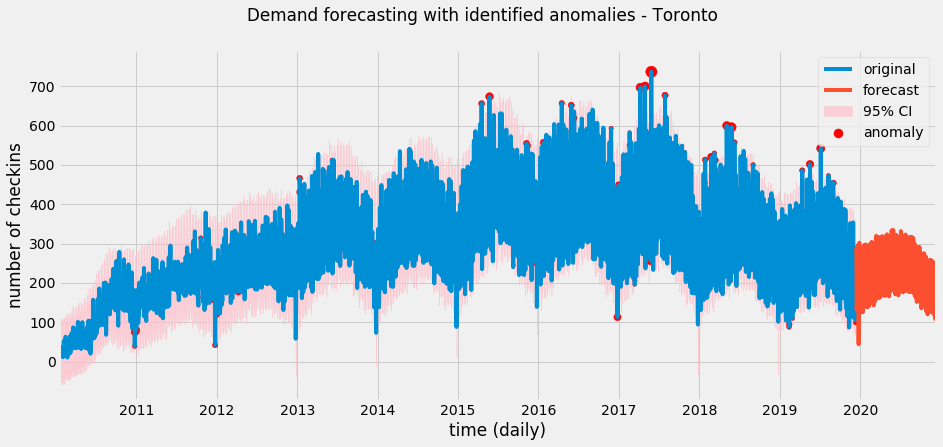

In [6]:
fig, ax = plt.subplots(figsize=(14,6))
ts_df.plot(y=city,label='original',ax=ax,linewidth=3)
ax.fill_between(x=pred.ds.values,y1=pred.yhat_lower,y2=pred.yhat_upper, \
                    color='pink',alpha=0.8,label='95% CI',linewidth=2)
anomaly_df.plot(kind='scatter', x='ds', y='fact', \
                    s=anomaly_df.importance.values,color='red',ax=ax, label='anomaly',linewidth=3)
fcast.plot(x='ds',y='yhat',ax=ax, label='forecast')
fig.suptitle('Demand forecasting with identified anomalies - '+city)
ax.set(xlabel='time (daily)', ylabel='number of checkins')
plt.legend()
plt.show()